In [22]:
import numpy as np
import pandas as pd
from data import get_train_test_split
from models.utils import damerau_levenshtein_distance
from tqdm import tqdm
from collections import Counter

In [93]:
class KNN:
    def __init__(self, k):
        """
        Args:
            k (int): number of nearst neighbours to consider
        """
        self.k = k
        self.destinations = {}
    
    def fit(self, dataset):
        for i in tqdm(range(len(dataset))):
            self.destinations[dataset.iloc[i]["destination"]] = dataset.iloc[i]["code"]
    
    def eval(self, dataset):
        """Evaluates the model on dataset
        
        Args:
            dataset (DataFrame): needs to have columns "destination" and "code" (i.e label)
        
        Returns:
            accuracy (float): the percentage of correct labels
        """
        
        correct = 0
        false_preds = []
        for i in tqdm(range(len(dataset))):
            text = dataset.iloc[i]["destination"]
            label = dataset.iloc[i]["code"]
            pred,_ = self(text)
            if pred == label: correct += 1
            else: false_preds.append((text, pred, label))

        return correct / len(dataset), false_preds
    
    @staticmethod
    def max_distance(text, elements):
        """Find the farthest element and returns its index
        Args:
            text (str): text to consider
            elements (double<str>): (destination, label)
        
        Returns:
            int: index of the farthest element
        """
        max_idx = 0
        max_distance = damerau_levenshtein_distance(text, elements[0][0])
        for i in range(1, len(elements)):
            if damerau_levenshtein_distance(text, elements[i][0]) > max_distance: 
                max_idx = i
                max_distance = damerau_levenshtein_distance(text, elements[i][0])
        return max_idx
    
    
    def __call__(self, text):
        """Classify text with the most common label amongst k-nearest neighbours
        
        Args:
            text (str): text to label
        
        Returns:
            label(str): the predicted label
            nearest_neighbours (list): list of k-nearest neighbours (from the training data)
        """
        
        nearest_neighbours = []
        for destination, label in self.destinations.items():
            if len(nearest_neighbours) < self.k: nearest_neighbours.append((destination, label))
            else:
                worst_neighbour_idx = self.max_distance(text, nearest_neighbours)
                nearest_neighbours[worst_neighbour_idx] = (destination, label)
        
        # find the best label
        label_counts = Counter([nn[1] for nn in nearest_neighbours])
        
        return label_counts.most_common()[0][0], nearest_neighbours

In [ ]:
train, test = get_train_test_split("10_ports.csv")

In [104]:
model = KNN(k=5)

In [105]:
model.fit(train)

100%|██████████| 198/198 [00:00<00:00, 4488.00it/s]


In [106]:
model.eval(test)

100%|██████████| 50/50 [00:04<00:00, 10.08it/s]


(0.9,
 [('ST.MALO/FRANCE.', 'FRBES', 'FRSML'),
  ('>NL RTM', 'FRMTX', 'NLRTM'),
  ('FRBOD', 'FRBES', 'FRBOD'),
  ('DUNKIRKE', 'NLRTM', 'FRIRK'),
  ('FR DON > FR LEH', 'FRMTX', 'FRLEH')])

In [107]:
accuracies = []

for k in tqdm(range(2, 8)):
    model = KNN(k=k)
    model.fit(train)
    acc,_ = model.eval(test)
    
    accuracies.append(acc)

100%|██████████| 198/198 [00:00<00:00, 4424.65it/s]

100%|██████████| 198/198 [00:00<00:00, 4232.63it/s]

100%|██████████| 198/198 [00:00<00:00, 4607.44it/s]

100%|██████████| 198/198 [00:00<00:00, 4378.70it/s]

100%|██████████| 198/198 [00:00<00:00, 4644.75it/s]

100%|██████████| 198/198 [00:00<00:00, 4289.61it/s]

 18%|█▊        | 9/50 [00:00<00:04,  9.29it/s]


100%|██████████| 6/6 [00:28<00:00,  4.74s/it]


[Text(0.5, 1.0, 'Accuracy'),
 Text(0.5, 0, 'k parameter'),
 Text(0, 0.5, 'Accuracy')]

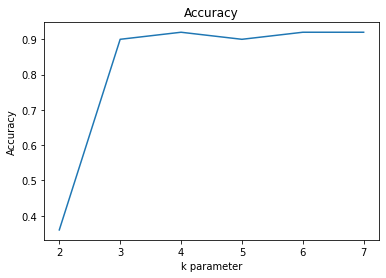

In [113]:
import seaborn as sns

sns.lineplot(x=range(2,8), y=accuracies).set(title="Accuracy", xlabel="k parameter", ylabel="Accuracy")